In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable 
from torch.utils.data.sampler import SubsetRandomSampler


import matplotlib as mpl
from matplotlib import pyplot as plt
from collections import namedtuple

from tqdm import tqdm
%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
!pip install --editable .

Obtaining file:///home/jupyter/neuron-hidden-inference
  Preparing metadata (setup.py) ... done
  Attempting uninstall: helper-functions
    Found existing installation: helper-functions 0.1.2
    Uninstalling helper-functions-0.1.2:
      Successfully uninstalled helper-functions-0.1.2
  Running setup.py develop for helper-functions


In [4]:
from helper_functions import get_default_device, to_device
from helper_functions import evaluate_model, r2_loss

In [5]:
device = get_default_device()
print(f'device: {device} \ndevice name: {torch.cuda.get_device_name()}')

device: cuda 
device name: Tesla V100-SXM2-16GB


In [6]:
# Set random seeds for numpy and torch
np.random.seed(42)
random_seed = 42
torch.manual_seed(random_seed)

In [2]:
class correlated_spikes(object):
    """ correlated_spikes Is the main class implemented [1]. Two basic methods
        are implemented in this script: Cox processes and the Mixture method.
    """

    def __init__(self, C, rates, n_proc):
        """ Constructor of correlated_spikes class.
            Args:
                C (mxm array)   : Is the correlation matrix (positive definite)
                                  Its diagonal contains the firing rates for
                                  the spike trains
                rates (m array) : Firing rates for spike trains (only for
                                  Mixture method)
                n_proc          : Number of processes (dimensions of C matrix)
            Returns:
        """
        self.n_proc = n_proc
        self.C = C
        self.r = rates
        self.spikes = 0

    def rectify_and_decomp_corr(self):
        """ rectify_and_decomp_corr - It rectifies and decomposes matrix C
            using Cholesky's decomposition.
            Args:
            Returns:
                L (mxm array)  : Lower triangular matrix (after Cholesky's
                                 decomposition) with diagona filled with r^2 *
                                 alpha (see [1])
        """
        # Change diagonal with r^2
        d = np.diag(self.C)**2
        np.fill_diagonal(self.C, d)

        # Cholesky decomposition
        L = np.linalg.cholesky(self.C)

        # Compute eigenvalues of L
        w, v = np.linalg.eig(L)

        # Compute alpha as the minimum eigenvalue with negative sign
        alpha = -w.real.min()

        # Fill the diagonal of L with r^2 * alpha
        np.fill_diagonal(L, d * alpha)

        return L

    def cox_process(self, tau_c=10, time=100, dt=1):
        """ Cox process (doubly stochastic process). It generates n_proc
            number of correlated spike trains based on C matrix.
            Args:
                tau_c (float)   : Time constant (lambda, see [1])
                time (int)      : Duration of spike trains (ms)
                dt (float)      : Time step (discretization)
        """
        ticks = int(time / dt)      # Simulation ticks

        Lambda = np.exp(-dt / tau_c)
        Sigma = np.sqrt(1 - np.exp(-2 * dt / tau_c))

        # Set up rates vector
        R = np.diag(self.C)
        Y = np.random.normal(0, 1, (self.n_proc,))
        S = np.zeros((ticks, self.n_proc))

        # Rectify C
        L = self.rectify_and_decomp_corr()

        for t in range(ticks):
            # Compute N independent Ornstein-Uhlberg processes
            Y = Y * Lambda + np.random.normal(0, Sigma, (self.n_proc,))

            # Compute instantaneous rates
            X = R + np.dot(L, Y)

            # Create spikes list
            prob = np.random.uniform(0, 1, (self.n_proc,))
            idx = (X * 0.001 * dt) > prob
            S[t, idx] = 1

        self.spikes = S.copy()
        return S

    def random_latency(self, size):
        """ random_latency - Returns a random number based on the exponential
            distribution.
            Args:
                size (int)  : Size of random numbers sample
            Returns:
        """
        return np.random.exponential(1, size=size)

    def optimization_mixture(self, nu, P):
        """ optimization_mixture - This function computes the best mixture
            matrix P and the corresponding vector nu (firing rates) by applying
            a gradient descent.
            Args:
                P (mx2n)  : Mixture matrix
                nu (2n)   : Firing rates of independent spike trains (sources)
            Returns:
        """
        n = self.n_proc
        P_ = P[:, :n].copy()
        nu_ = nu[:n].copy()
        A = np.zeros((n, n))

        # Initialization of nu and P
        nu_ = self.r.copy()
        np.fill_diagonal(P_, 1)

        # Steps
        b = 0.01 / n
        a = (1. / n) * b

        # Iterations
        U = np.zeros((n, ))
        for ns in range(20000):
            for i in range(n):
                for j in range(n):
                    if i != j:
                        x = 0.0
                        for k in range(n):
                            x += P_[i, k] * P_[j, k] * nu_[k]
                        A[i, j] = x - self.C[i, j]
                    else:
                        A[i, j] = 0

            tmp = np.dot(nu_.T, P_)
            U[tmp >= self.r] = 1
            U[tmp < self.r] = 0

            tmp = np.dot(A, P_)
            tmp_y = np.dot(tmp, nu_)
            tmp_u = np.dot(U, nu_)

            Y = P_ - 4 * a * tmp_y - b * tmp_u

            Y[Y < 0] = 0
            Y[Y > 1] = 1
            P_ = Y

            for i in range(n):
                X = 0
                for k in range(n):
                    for l in range(n):
                        X += P_[k, i] * P_[l, i] * A[k, l]

                Y = np.dot(U, P_)
                nu_[i] -= a * X + b * Y[i]
                nu_[nu_ < 0] = 0

        X = np.dot(P_, nu_)
        nu[:n] = nu_.copy()
        nu[n:] = (self.r - X)

        P[:, :n] = P_
        P[:, n:] = np.zeros((n, n))
        np.fill_diagonal(P[:, n:], 1)

        if any(nu[nu < 0]):
            raise ValueError("nu contains illegal values!")

        if any(P[P < 0]) or any(P[P > 1]):
            raise ValueError("P contains illegal values!")

    def offline_mixture(self, P, nu, n_src=1, n_trg=1, tau_c=10, time=1000):
        """ offline_mixture - It's the Mixture methods implemented in [1].
            It returns a spike list containing correlated spike trains.
            Args:
                P (mx2n array) : Mixture matrix (mixture probability)
                nu (2x array)  : Firing rates of independent spike trains
                                 (sources)
                n_src (int)    : Number of sources spike trains
                n_trg (int)    : Number of targets (correlated) spike trains
                tau_c (float)  : Time constant
                time           : Duration of correlated spike trains
            Returns:
                spks (array)   : Numpy structured array containing events time
                                 and ids (id is the number of target spike
                                 train)
        """
        # Average target rate
        r_mean = np.mean(np.dot(P, nu))

        # Optimal window size
        w_size = n_src * 1.0 / r_mean

        # Window
        w_size = int(time * 0.001)

        # Number of spikes in trains
        num_sources = np.random.poisson(nu * w_size).astype('int')

        # Generate Poisson spike trains
        source_train = []
        for i in range(num_sources.shape[0]):
            source_train.append(np.random.uniform(
                0, w_size, num_sources[i]) * 1000)

        spk, tm = [], []
        for i in range(n_src):
            for j in range(n_trg):
                num_targets = np.random.binomial(num_sources[i], P[j, i])
                target_train = np.random.choice(source_train[i],
                                                size=num_targets,
                                                replace=False)
                spk.extend(np.ones((num_targets,)) * j)
                tm.extend(target_train +
                          self.random_latency(num_targets) * tau_c)
        spk = np.array(spk, dtype='int')
        tm = np.array(tm)

        spks = np.recarray(spk.shape[0], dtype=[('t', float), ('id', int)])
        spks['t'] = tm
        spks['id'] = spk
        spks.sort()
        return spks

    def extract_pyNCS_list(self, id_init=0):
        """ extract_pyNCS_list - Extracts a spike list compatible with pyNCS
            package.
            Args:
                id_init (int) : Initial id for spike trains
            Returns:
                tmp (array)   : A spike list that is compatible to pyNCS AER.
        """
        time, id_end = self.spikes.shape
        id_end += id_init
        ids = range(id_init, id_end)
        tmp = []
        for t in range(time):
            for i, j in enumerate(ids):
                if self.spikes[t, i] != 0:
                    tmp.append((j, t))
        return np.array(tmp, dtype='int')

    def raster_plot(self):
        """ raster_plot - Draws the raster plot of already generated spike
            trains.
            Args:
            Returns:
        """
        self.spikes[self.spikes == 0] = np.nan

        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i in range(self.n_proc):
            ax.plot(self.spikes[:, i] + i, '|k', ms=20, mew=1)
        ax.set_ylim([-.5, self.n_proc + 1])
        ax.set_yticks([])

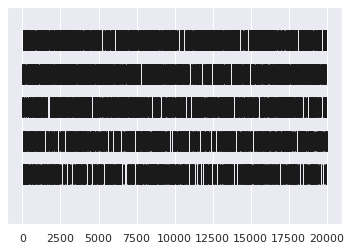

In [30]:
# Cox proces method 

'''
C (mxm array)   : Is the correlation matrix (positive definite)
                                  Its diagonal contains the firing rates for
                                  the spike trains
                rates (m array) : Firing rates for spike trains (only for
                                  Mixture method)
                n_proc          : Number of processes (dimensions of C matrix)

  tau_c (float)   : Time constant (lambda, see [1])
                time (int)      : Duration of spike trains (ms)
                dt (float)      : Time step (discretization)
'''

n_proc = 5

C = (np.ones((n_proc, n_proc)) +
     np.random.uniform(0, 1, (n_proc, n_proc)) * 5.0)

np.fill_diagonal(C, [5, 6, 7, 8, 9])

C = np.maximum(C, C.T)
# C = np.ones((n_proc, n_proc))
rates = np.array([5, 15, 4, 6, 7])

cor_spk = correlated_spikes(C, rates, n_proc)
spikes = cor_spk.cox_process(time=20000)
cor_spk.raster_plot()
spk = cor_spk.extract_pyNCS_list()
plt.show()

In [32]:
print(spikes, spikes.shape)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] (20000, 5)


In [13]:
# Mixture method 
n_proc = 5
P = np.random.randint(0, 2, (n_proc, n_proc))
nu = np.random.random(n_proc) * 50

C = (np.ones((n_proc, n_proc)) +
     np.random.uniform(0, 1, (n_proc, n_proc)) * 5.0)

np.fill_diagonal(C, [5, 6, 7, 8, 9])

C = np.maximum(C, C.T)

rates = np.array([5, 15, 4, 6, 7])

cor_spk = correlated_spikes(C, rates, n_proc)
res = cor_spk.offline_mixture(P, nu, n_src=5, n_trg=5, time=500000)


In [20]:
import pandas as pd


In [21]:
df = pd.DataFrame(res)

In [22]:
df

,t,id
0,10.260987,0
1,13.954408,1
2,20.666973,1
3,28.926019,0
4,29.106481,1
...,...,...
153393,499993.545940,4
153394,499996.779841,1
153395,500000.853790,2
153396,500001.322467,0
